# Floresta Aleatória
**Variáveis Desagregadas (2010-2017)** \\
 \\
Bootcamp Machine Learning ENAP 2024 \\
Maurício Marques Soares Filho \\
25/10/2024 \\

## Imports...

In [1]:
!pip install dtreeviz
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.1 MB/s eta 0:00:00


In [2]:
###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dtreeviz

###
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.inspection import permutation_importance

###
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

###
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV

###
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier


###
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV

###
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Pré-processamento dos dados

In [3]:
#Estilizar conteúdo
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

def estilo_tabelas(df, max_altura = '300px', casas_decimais = 3):
    return (
        df.style.set_table_styles(
            [
                {'selector': 'thead th', 'props': [('font-size', '12px'), ('text-align', 'center'), ('border-bottom', '2px solid #007BFF')]},
                {'selector': 'td', 'props': [('font-size', '10px'), ('text-align', 'center'), ('max-height', '40px'), ('white-space', 'nowrap'), ('text-overflow', 'ellipsis'), ('overflow', 'hidden'), ('max-width', '100px')]},
                {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]},
                {'selector': 'table', 'props': [('width', '90%'), ('margin-left', 'auto'), ('margin-right', 'auto'), ('border-collapse', 'collapse')]},
                {'selector': 'td, th', 'props': [('border', '1px solid #666')]},  # Bordas cinza escuro
            ]
        ).set_properties(
            **{'border-color': 'darkgray', 'border-style': 'solid', 'border-width': '1px'}
        ).set_table_attributes(
            f'style = "height:auto; overflow:auto; max-height:{max_altura}; display:block;"'
        ).format(
            precision=casas_decimais
        )
    )

In [4]:
# Importar a base de dados
df_eventos_2010_2017_modelo2 = pd.read_csv(
    "https://raw.githubusercontent.com/brunagmoura/PrevisorReconhecimento/refs/heads/main/df_eventos_2010_2017_modelo2.csv",
    sep = ';',
    decimal = ',',
)

estilo_tabelas(df_eventos_2010_2017_modelo2.head(5))

,Status,DH_MORTOS,DH_FERIDOS,DH_ENFERMOS,DH_DESABRIGADOS,DH_DESALOJADOS,DH_DESAPARECIDOS,DH_OUTROS AFETADOS,DM_Uni Habita Danificadas,DM_Uni Habita Destruidas,DM_Uni Habita Valor,DM_Inst Saúde Danificadas,DM_Inst Saúde Destruidas,DM_Inst Saúde Valor,DM_Inst Ensino Danificadas,DM_Inst Ensino Destruidas,DM_Inst Ensino Valor,DM_Inst Serviços Danificadas,DM_Inst Serviços Destruidas,DM_Inst Serviços Valor,DM_Inst Comuni Danificadas,DM_Inst Comuni Destruidas,DM_Inst Comuni Valor,DM_Obras de Infra Danificadas,DM_Obras de Infra Destruidas,DM_Obras de Infra Valor,PEPL_Assis_méd e emergên(R$),PEPL_Abast de água pot(R$),PEPL_sist de esgotos sanit(R$),PEPL_Sis limp e rec lixo (R$),PEPL_Sis cont pragas (R$),PEPL_distrib energia (R$),PEPL_Telecomunicações (R$),PEPL_Tran loc/reg/l_curso (R$),PEPL_Distrib combustíveis(R$),PEPL_Segurança pública (R$),PEPL_Ensino (R$),PEPR_Agricultura (R$),PEPR_Pecuária (R$),PEPR_Indústria (R$),PEPR_Comércio (R$),PEPR_Serviços (R$),DensidadePop,Rendapercapita,Sigla_UF_AC,Sigla_UF_AL,Sigla_UF_AM,Sigla_UF_AP,Sigla_UF_BA,Sigla_UF_CE,Sigla_UF_DF,Sigla_UF_ES,Sigla_UF_GO,Sigla_UF_MA,Sigla_UF_MG,Sigla_UF_MS,Sigla_UF_MT,Sigla_UF_PA,Sigla_UF_PB,Sigla_UF_PE,Sigla_UF_PI,Sigla_UF_PR,Sigla_UF_RJ,Sigla_UF_RN,Sigla_UF_RO,Sigla_UF_RR,Sigla_UF_RS,Sigla_UF_SC,Sigla_UF_SE,Sigla_UF_SP,Sigla_UF_TO,Sigla_UF_pa,COBRADE_11110,COBRADE_11120,COBRADE_11311,COBRADE_11312,COBRADE_11313,COBRADE_11321,COBRADE_11331,COBRADE_11332,COBRADE_11340,COBRADE_11410,COBRADE_11420,COBRADE_11431,COBRADE_11432,COBRADE_11433,COBRADE_12100,COBRADE_12200,COBRADE_12300,COBRADE_13111,COBRADE_13112,COBRADE_13120,COBRADE_13211,COBRADE_13212,COBRADE_13213,COBRADE_13214,COBRADE_13215,COBRADE_13310,COBRADE_13321,COBRADE_13322,COBRADE_14110,COBRADE_14120,COBRADE_14131,COBRADE_14132,COBRADE_14140,COBRADE_15110,COBRADE_15120,COBRADE_15130,COBRADE_15210,COBRADE_15230,COBRADE_22210,COBRADE_22220,COBRADE_23120,COBRADE_24100,COBRADE_24200,COBRADE_25100,COBRADE_25500
0,1,0,0,0,0,0,0,4000,0,0,0.000,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,8.000,2.000,166542.286,0.000,0.000,0.000,0.000,0.000,0.000,0.000,6078793.423,0.000,0.000,41635.571,5204446.424,0.000,0.000,0.000,2081778.549,60.642,17.934,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1,0,0,0,0,0,0,8034,0,0,0.000,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3395323.196,4244153.995,0.000,0.000,0.000,nan,5.605,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,1,0,0,0,0,0,0,2732,0,0,0.000,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,26406.490,0.000,2.079,13.655,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,1,0,0,0,0,0,0,0,0,0,0.000,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0

In [5]:
# Remover linhas com dados ausentes
df_eventos_2010_2017_modelo2 = df_eventos_2010_2017_modelo2.dropna()
estilo_tabelas(df_eventos_2010_2017_modelo2.head(5))

# Remover linhas com todos os dados nulos
colunas_informados = [
    'DH_MORTOS', 'DH_FERIDOS', 'DH_ENFERMOS', 'DH_DESABRIGADOS', 'DH_DESALOJADOS',
    'DH_DESAPARECIDOS', 'DH_OUTROS AFETADOS',
    'DM_Uni Habita Danificadas', 'DM_Uni Habita Destruidas', 'DM_Uni Habita Valor',
    'DM_Inst Saúde Danificadas', 'DM_Inst Saúde Destruidas', 'DM_Inst Saúde Valor',
    'DM_Inst Ensino Danificadas', 'DM_Inst Ensino Destruidas', 'DM_Inst Ensino Valor',
    'DM_Inst Serviços Danificadas', 'DM_Inst Serviços Destruidas', 'DM_Inst Serviços Valor',
    'DM_Inst Comuni Danificadas', 'DM_Inst Comuni Destruidas', 'DM_Inst Comuni Valor',
    'DM_Obras de Infra Danificadas', 'DM_Obras de Infra Destruidas', 'DM_Obras de Infra Valor',
    'PEPL_Assis_méd e emergên(R$)', 'PEPL_Abast de água pot(R$)',
    'PEPL_sist de esgotos sanit(R$)', 'PEPL_Sis limp e rec lixo (R$)', 'PEPL_Sis cont pragas (R$)',
    'PEPL_distrib energia (R$)', 'PEPL_Telecomunicações (R$)', 'PEPL_Tran loc/reg/l_curso (R$)',
    'PEPL_Distrib combustíveis(R$)', 'PEPL_Segurança pública (R$)', 'PEPL_Ensino (R$)',
    'PEPR_Agricultura (R$)', 'PEPR_Pecuária (R$)', 'PEPR_Indústria (R$)', 'PEPR_Comércio (R$)',
    'PEPR_Serviços (R$)'
]

df_eventos_2010_2017_modelo2 = df_eventos_2010_2017_modelo2[
    ~(df_eventos_2010_2017_modelo2[colunas_informados] == 0).all(axis=1)
]

In [6]:
# Dimensões do dataset
status_counts = df_eventos_2010_2017_modelo2['Status'].value_counts()
print("\nContagem da variável 'Status':")
status_counts.index=['Reconhecido', 'Não Reconhecido']
display(status_counts)


Contagem da variável 'Status':


,count
Reconhecido,6117
Não Reconhecido,721


## Modelo Sem Balanceamento

In [7]:
# Divisão em Dados de Treino e Teste
df_eventos_2010_2017_modelo2 = df_eventos_2010_2017_modelo2.sample(frac = 1, random_state = 42).reset_index(drop = True, inplace = False)
X_2010_2017_modelo2 = df_eventos_2010_2017_modelo2.drop('Status', axis = 1)
y_2010_2017_modelo2 = df_eventos_2010_2017_modelo2['Status']
X_train_2010_2017_modelo2, X_test_2010_2017_modelo2, y_train_2010_2017_modelo2, y_test_2010_2017_modelo2 = train_test_split(X_2010_2017_modelo2, y_2010_2017_modelo2, test_size = 0.2, random_state = 42, stratify = y_2010_2017_modelo2)

# Dimensões do dataset de treino
status_counts = y_train_2010_2017_modelo2.value_counts()
print("\nDimensões do dataset de treino:")
status_counts.index=['Reconhecido', 'Não Reconhecido']
display(status_counts)

# Dimensões do dataset de teste
status_counts = y_test_2010_2017_modelo2.value_counts()
print("\nDimensões do dataset de teste:")
status_counts.index=['Reconhecido', 'Não Reconhecido']
display(status_counts)


Dimensões do dataset de treino:


,count
Reconhecido,4893
Não Reconhecido,577



Dimensões do dataset de teste:


,count
Reconhecido,1224
Não Reconhecido,144


In [8]:
# Treinamento

# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes = {
    'rf_class_0__criterion': ['gini', 'entropy'],
    'rf_class_0__n_estimators': [150, 175, 200, 225, 250, 300],
    'rf_class_0__max_depth': [2, 4, 6, 8],
    'rf_class_0__min_samples_split': [2, 5, 10, 15, 100],
    'rf_class_0__min_samples_leaf': [1, 2, 5, 10],
    'rf_class_0__max_features': ['sqrt', 'log2', None]
}

# Criar pipeline com RobustScaler e RandomForestClassifier
pipeline_rf_class_0 = Pipeline([
    ('scaler', RobustScaler()),
    ('rf_class_0', RandomForestClassifier(random_state = 42))
])

# Realizar a busca bayesiana com validação cruzada
bayes_search_rf_class_0 = BayesSearchCV(
    pipeline_rf_class_0,
    search_spaces = param_grid_bayes,
    n_iter = 30,
    cv = 5,
    scoring = 'f1_weighted',
    n_jobs = -1,
    random_state = 42
)

# Ajustar a busca bayesiana ao conjunto de treino
bayes_search_rf_class_0.fit(X_train_2010_2017_modelo2, y_train_2010_2017_modelo2)

# Melhor modelo encontrado
best_rf_class_0_model = bayes_search_rf_class_0.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros: {bayes_search_rf_class_0.best_params_}")

# Fazer previsões com o conjunto de teste
y_pred_rf_class_0 = best_rf_class_0_model.predict(X_test_2010_2017_modelo2)

# Relatório de classificação TREINO
classification_report_rf_class_0 = metrics.classification_report(y_train_2010_2017_modelo2, best_rf_class_0_model.predict(X_train_2010_2017_modelo2), digits = 6, target_names = ['Não reconhecido', 'Reconhecido'])
print('\n Classification report para Random Forest [TREINO]: \n')
print(classification_report_rf_class_0)

# Relatório de classificação TESTE
classification_report_rf_class_0 = metrics.classification_report(y_test_2010_2017_modelo2, y_pred_rf_class_0, digits = 6, target_names = ['Não reconhecido', 'Reconhecido'])
print('\n Classification report para Random Forest [TESTE]: \n')
print(classification_report_rf_class_0)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast


Melhores hiperparâmetros: OrderedDict([('rf_class_0__criterion', 'gini'), ('rf_class_0__max_depth', 8), ('rf_class_0__max_features', None), ('rf_class_0__min_samples_leaf', 1), ('rf_class_0__min_samples_split', 2), ('rf_class_0__n_estimators', 300)])

 Classification report para Random Forest [TREINO]: 

                 precision    recall  f1-score   support

Não reconhecido   1.000000  0.178510  0.302941       577
    Reconhecido   0.911683  1.000000  0.953801      4893

       accuracy                       0.913346      5470
      macro avg   0.955841  0.589255  0.628371      5470
   weighted avg   0.920999  0.913346  0.885146      5470


 Classification report para Random Forest [TESTE]: 

                 precision    recall  f1-score   support

Não reconhecido   0.769231  0.069444  0.127389       144
    Reconhecido   0.901107  0.997549  0.946879      1224

       accuracy                       0.899854      1368
      macro avg   0.835169  0.533497  0.537134      1368
   weigh

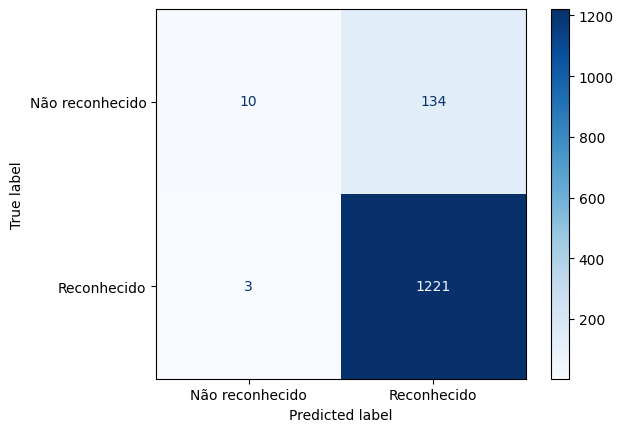

In [9]:
# Matriz de Confusão
ConfusionMatrixDisplay.from_estimator(best_rf_class_0_model, X_test_2010_2017_modelo2, y_test_2010_2017_modelo2, values_format='d', cmap='Blues', display_labels=['Não reconhecido', 'Reconhecido'])

## Balanceamento de Dados com SMOTE

In [10]:
# Divisão em Dados de Treino e Teste
X_smote = df_eventos_2010_2017_modelo2.drop('Status', axis=1)
y_smote = df_eventos_2010_2017_modelo2['Status']
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size = 0.2, random_state = 42, stratify = y_smote)

In [11]:
# Aplicar SMOTE apenas no conjunto de treino
smote = SMOTE(random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_smote, y_train_smote)

In [12]:
# Treinamento

# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes = {
    'rf_class_1__criterion': ['gini', 'entropy'],
    'rf_class_1__n_estimators': [150, 175, 200, 225, 250, 300],
    'rf_class_1__max_depth': [2, 4, 6, 8],
    'rf_class_1__min_samples_split': [2, 5, 10, 15, 100],
    'rf_class_1__min_samples_leaf': [1, 2, 5, 10],
    'rf_class_1__max_features': ['sqrt', 'log2', None]
}

# Criar pipeline com RobustScaler e RandomForestClassifier
pipeline_rf_class_1 = Pipeline([
    ('scaler', RobustScaler()),
    ('rf_class_1', RandomForestClassifier(random_state = 42))
])

# Realizar a busca bayesiana com validação cruzada
bayes_search_rf_class_1 = BayesSearchCV(
    pipeline_rf_class_1,
    search_spaces = param_grid_bayes,
    n_iter = 30,
    cv = 5,
    scoring = 'f1_weighted',
    n_jobs = -1,
    random_state = 42
)

# Ajustar a busca bayesiana ao conjunto de treino
bayes_search_rf_class_1.fit(X_train_smote, y_train_smote)

# Melhor modelo encontrado
best_rf_class_1_model = bayes_search_rf_class_1.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros: {bayes_search_rf_class_1.best_params_}")

# Fazer previsões com o conjunto de teste
y_pred_rf_class_1 = best_rf_class_1_model.predict(X_test_smote)

# Relatório de classificação TREINO
classification_report_rf_class_1 = metrics.classification_report(y_train_smote, best_rf_class_1_model.predict(X_train_smote), digits = 6, target_names = ['Não reconhecido', 'Reconhecido'])
print('\n Classification report para Random Forest com SMOTE [TREINO]: \n')
print(classification_report_rf_class_1)


# Relatório de classificação TESTE
classification_report_rf_class_1 = metrics.classification_report(y_test_smote, y_pred_rf_class_1, digits = 6, target_names = ['Não reconhecido', 'Reconhecido'])
print('\n Classification report para Random Forest com SMOTE [TESTE]: \n')
print(classification_report_rf_class_1)

Melhores hiperparâmetros: OrderedDict([('rf_class_1__criterion', 'entropy'), ('rf_class_1__max_depth', 8), ('rf_class_1__max_features', None), ('rf_class_1__min_samples_leaf', 2), ('rf_class_1__min_samples_split', 2), ('rf_class_1__n_estimators', 225)])

 Classification report para Random Forest com SMOTE [TREINO]: 

                 precision    recall  f1-score   support

Não reconhecido   0.957802  0.890660  0.923012      4893
    Reconhecido   0.897823  0.960760  0.928226      4893

       accuracy                       0.925710      9786
      macro avg   0.927812  0.925710  0.925619      9786
   weighted avg   0.927812  0.925710  0.925619      9786


 Classification report para Random Forest com SMOTE [TESTE]: 

                 precision    recall  f1-score   support

Não reconhecido   0.428571  0.333333  0.375000       144
    Reconhecido   0.923567  0.947712  0.935484      1224

       accuracy                       0.883041      1368
      macro avg   0.676069  0.640523  0.65

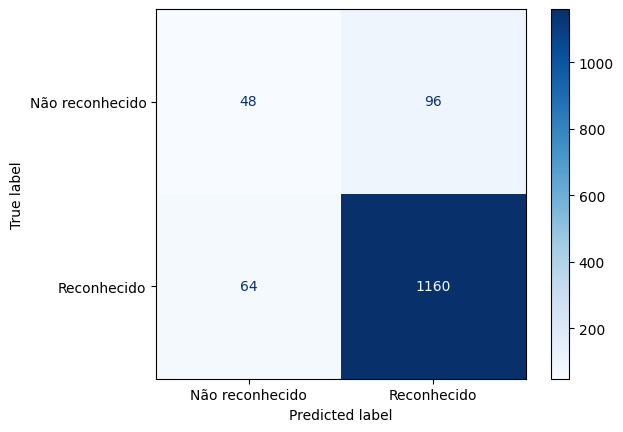

In [13]:
# Matriz de Confusão
ConfusionMatrixDisplay.from_estimator(best_rf_class_1_model, X_test_smote, y_test_smote, values_format='d', cmap='Blues', display_labels=['Não reconhecido', 'Reconhecido'])

## Avaliação das Variáveis de Importância
Avaliação das variáveis de importância de acordo com o modelo desbalanceado,  que apresentou o maior f1-score.

In [15]:
# Passo intermediário
X_train     = X_train_2010_2017_modelo2
y_train     = y_train_2010_2017_modelo2
X_test      = X_test_2010_2017_modelo2
y_test      = y_test_2010_2017_modelo2
model_type  = 'rf_class_0'
best_model  = best_rf_class_0_model

# Ajustar o melhor modelo encontrado (depois da busca bayesiana)
best_model.named_steps[model_type].fit(X_train, y_train)

# Obter a importância das features
importance_dict = {}
for feature, importance in zip(X_train.columns, best_model.named_steps[model_type].feature_importances_):
    importance_dict[feature] = importance
#importance_dict

# Transformar em DataFrame para organizar como tabela
importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Importance': list(importance_dict.values())
})

# Ordenar pela importância em ordem decrescente
importance_df = importance_df.sort_values(by = 'Importance', ascending = False)
estilo_tabelas(importance_df.head(10))

,Feature,Importance
36,PEPR_Agricultura (R$),0.085
42,Rendapercapita,0.082
69,Sigla_UF_TO,0.082
6,DH_OUTROS AFETADOS,0.064
24,DM_Obras de Infra Valor,0.059
41,DensidadePop,0.047
26,PEPL_Abast de água pot(R$),0.038
4,DH_DESALOJADOS,0.033
28,PEPL_Sis limp e rec lixo (R$),0.031
66,Sigla_UF_SC,0.030


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names


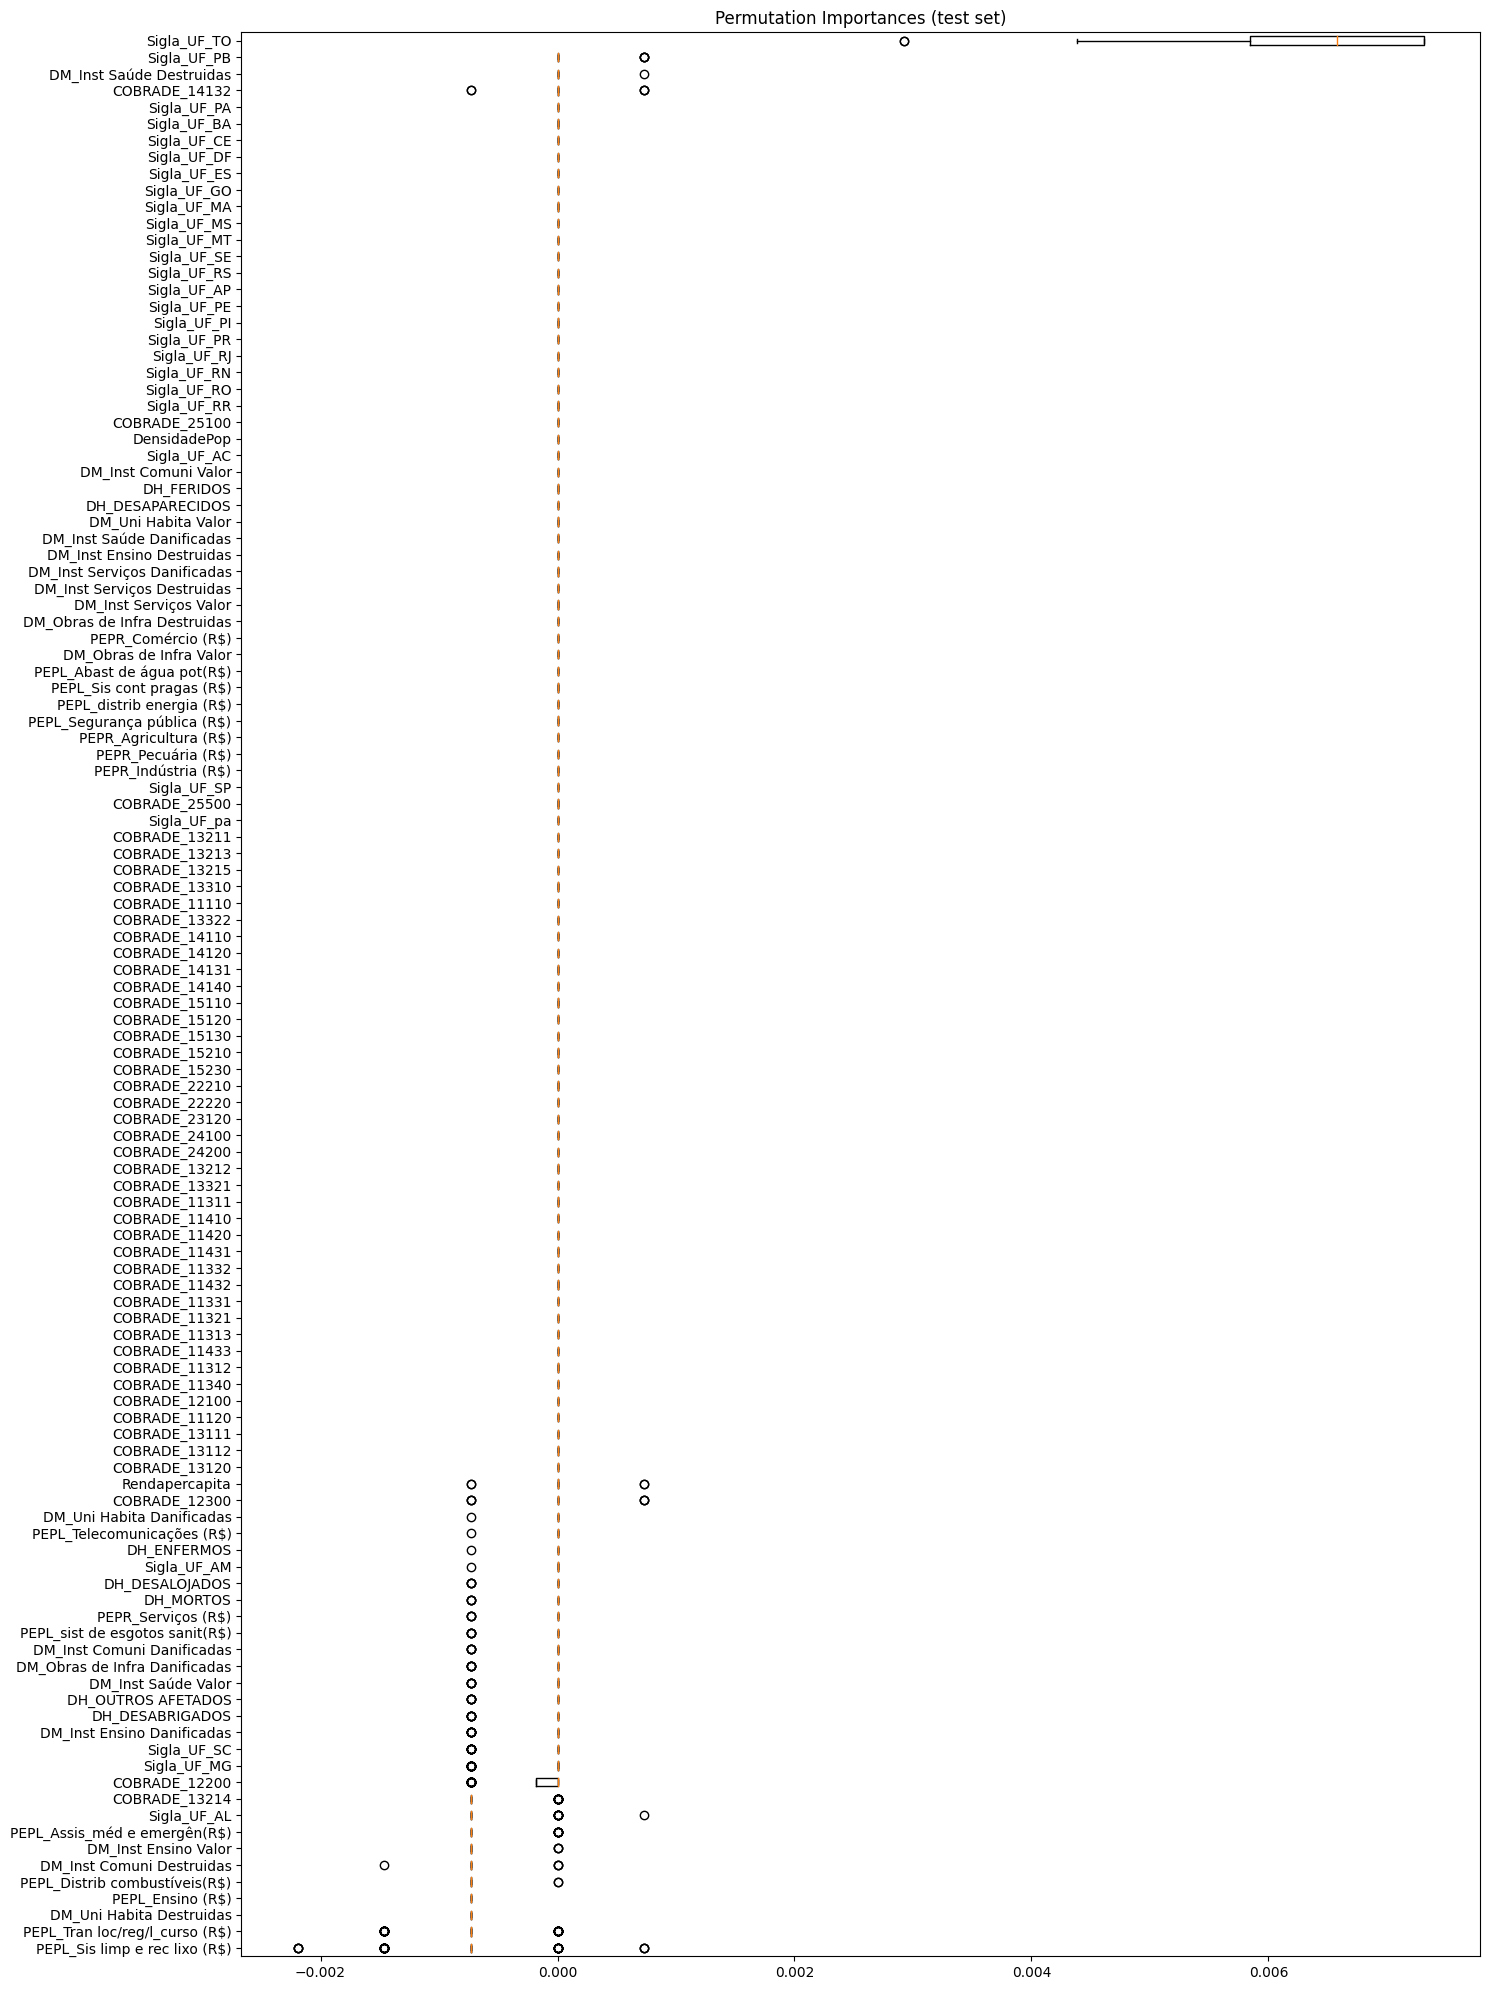

In [20]:
# Calcular os resultados (permutation_importance) da queda no desempenho do modelo ao embaralhar cada uma das variáveis.
result = permutation_importance(best_model, X_test, y_test, n_repeats = 100, random_state = 42, n_jobs = -1)

# Ordenar os resultados
sorted_idx = result.importances_mean.argsort()

# Gráfico boxplot pra mostrar a importância das variáveis
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert = False, labels = X_test.columns[sorted_idx])
ax.set_title('Permutation Importances (test set)')
fig.set_size_inches(15, 20)
fig.tight_layout()
plt.show()

## Seleção de Variáveis

### Importância Média > 0.00

In [21]:
# Filtrar as variáveis com importância média > 0
positive_idx = result.importances_mean > 0.0

# Selecionar apenas as colunas das features com importância positiva
selected_features = X_test.columns[positive_idx]

# Criar novos datasets apenas com essas features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Exibir as features selecionadas
print('Número de Features:', len(selected_features))
print('Features selecionadas:', selected_features.tolist())

Número de Features: 4
Features selecionadas: ['DM_Inst Saúde Destruidas', 'Sigla_UF_PB', 'Sigla_UF_TO', 'COBRADE_14132']


In [28]:
# Treinamento

# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes = {
    'rf_class_0__criterion': ['gini', 'entropy'],
    'rf_class_0__n_estimators': [150, 175, 200, 225, 250, 300],
    'rf_class_0__max_depth': [2, 4, 6, 8],
    'rf_class_0__min_samples_split': [2, 5, 10, 15, 100],
    'rf_class_0__min_samples_leaf': [1, 2, 5, 10],
    'rf_class_0__max_features': ['sqrt', 'log2', None]
}

# Criar pipeline com RobustScaler e RandomForestClassifier
pipeline_rf_class_0 = Pipeline([
    ('scaler', RobustScaler()),
    ('rf_class_0', RandomForestClassifier(random_state = 42))
])

# Realizar a busca bayesiana com validação cruzada
bayes_search_rf_class_0 = BayesSearchCV(
    pipeline_rf_class_0,
    search_spaces = param_grid_bayes,
    n_iter = 30,
    cv = 5,
    scoring = 'f1_weighted',
    n_jobs = -1,
    random_state = 42
)

# Ajustar a busca bayesiana ao conjunto de treino
bayes_search_rf_class_0.fit(X_train_selected, y_train)

# Melhor modelo encontrado
best_rf_class_0_model = bayes_search_rf_class_0.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros: {bayes_search_rf_class_0.best_params_}")

# Fazer previsões com o conjunto de teste
y_pred_rf_class_0 = best_rf_class_0_model.predict(X_test_selected)

# Relatório de classificação TREINO
classification_report_rf_class_0 = metrics.classification_report(y_train, best_rf_class_0_model.predict(X_train_selected), digits = 6, target_names = ['Não reconhecido', 'Reconhecido'])
print('\n Classification report para Random Forest [TREINO]: \n')
print(classification_report_rf_class_0)

# Relatório de classificação TESTE
classification_report_rf_class_0 = metrics.classification_report(y_test, y_pred_rf_class_0, digits = 6, target_names = ['Não reconhecido', 'Reconhecido'])
print('\n Classification report para Random Forest [TESTE]: \n')
print(classification_report_rf_class_0)

Melhores hiperparâmetros: OrderedDict([('rf_class_0__criterion', 'gini'), ('rf_class_0__max_depth', 8), ('rf_class_0__max_features', None), ('rf_class_0__min_samples_leaf', 1), ('rf_class_0__min_samples_split', 2), ('rf_class_0__n_estimators', 300)])

 Classification report para Random Forest [TREINO]: 

                 precision    recall  f1-score   support

Não reconhecido   1.000000  0.178510  0.302941       577
    Reconhecido   0.911683  1.000000  0.953801      4893

       accuracy                       0.913346      5470
      macro avg   0.955841  0.589255  0.628371      5470
   weighted avg   0.920999  0.913346  0.885146      5470


 Classification report para Random Forest [TESTE]: 

                 precision    recall  f1-score   support

Não reconhecido   0.769231  0.069444  0.127389       144
    Reconhecido   0.901107  0.997549  0.946879      1224

       accuracy                       0.899854      1368
      macro avg   0.835169  0.533497  0.537134      1368
   weigh

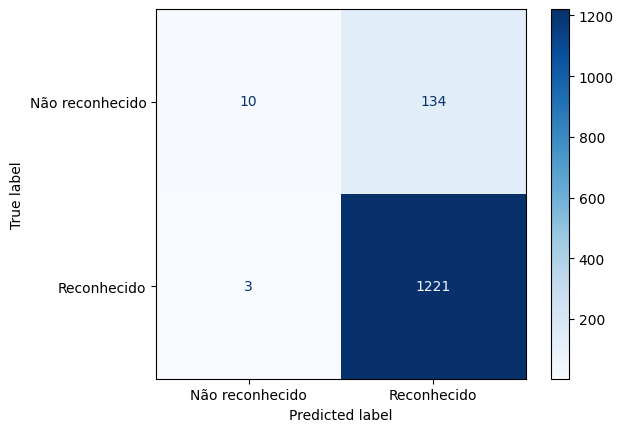

In [29]:
# Matriz de Confusão
ConfusionMatrixDisplay.from_estimator(best_rf_class_0_model, X_test_selected, y_test, values_format='d', cmap='Blues', display_labels=['Não reconhecido', 'Reconhecido'])

### Impotância > -0.00001



In [36]:
# Filtrar as variáveis com importância média > -0.00001
positive_idx = result.importances_mean > -0.00001

# Selecionar apenas as colunas das features com importância positiva
selected_features = X_test.columns[positive_idx]

# Criar novos datasets apenas com essas features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Exibir as features selecionadas
print('Número de Features:', len(selected_features))
print('Features selecionadas:', selected_features.tolist())

Número de Features: 93
Features selecionadas: ['DH_FERIDOS', 'DH_ENFERMOS', 'DH_DESAPARECIDOS', 'DM_Uni Habita Danificadas', 'DM_Uni Habita Valor', 'DM_Inst Saúde Danificadas', 'DM_Inst Saúde Destruidas', 'DM_Inst Ensino Destruidas', 'DM_Inst Serviços Danificadas', 'DM_Inst Serviços Destruidas', 'DM_Inst Serviços Valor', 'DM_Inst Comuni Valor', 'DM_Obras de Infra Destruidas', 'DM_Obras de Infra Valor', 'PEPL_Abast de água pot(R$)', 'PEPL_Sis cont pragas (R$)', 'PEPL_distrib energia (R$)', 'PEPL_Telecomunicações (R$)', 'PEPL_Segurança pública (R$)', 'PEPR_Agricultura (R$)', 'PEPR_Pecuária (R$)', 'PEPR_Indústria (R$)', 'PEPR_Comércio (R$)', 'DensidadePop', 'Rendapercapita', 'Sigla_UF_AC', 'Sigla_UF_AM', 'Sigla_UF_AP', 'Sigla_UF_BA', 'Sigla_UF_CE', 'Sigla_UF_DF', 'Sigla_UF_ES', 'Sigla_UF_GO', 'Sigla_UF_MA', 'Sigla_UF_MS', 'Sigla_UF_MT', 'Sigla_UF_PA', 'Sigla_UF_PB', 'Sigla_UF_PE', 'Sigla_UF_PI', 'Sigla_UF_PR', 'Sigla_UF_RJ', 'Sigla_UF_RN', 'Sigla_UF_RO', 'Sigla_UF_RR', 'Sigla_UF_RS', 'Sig

In [41]:
# Treinamento

# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes = {
    'rf_class_0__criterion': ['gini', 'entropy'],
    'rf_class_0__n_estimators': [150, 175, 200, 225, 250, 300],
    'rf_class_0__max_depth': [2, 4, 6, 8],
    'rf_class_0__min_samples_split': [2, 5, 10, 15, 100],
    'rf_class_0__min_samples_leaf': [1, 2, 5, 10],
    'rf_class_0__max_features': ['sqrt', 'log2', None]
}

# Criar pipeline com RobustScaler e RandomForestClassifier
pipeline_rf_class_0 = Pipeline([
    ('scaler', RobustScaler()),
    ('rf_class_0', RandomForestClassifier(random_state = 42))
])

# Realizar a busca bayesiana com validação cruzada
bayes_search_rf_class_0 = BayesSearchCV(
    pipeline_rf_class_0,
    search_spaces = param_grid_bayes,
    n_iter = 30,
    cv = 5,
    scoring = 'f1_weighted',
    n_jobs = -1,
    random_state = 42
)

# Ajustar a busca bayesiana ao conjunto de treino
bayes_search_rf_class_0.fit(X_train_selected, y_train)

# Melhor modelo encontrado
best_rf_class_0_model = bayes_search_rf_class_0.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros: {bayes_search_rf_class_0.best_params_}")

# Fazer previsões com o conjunto de teste
y_pred_rf_class_0 = best_rf_class_0_model.predict(X_test_selected)

# Relatório de classificação TREINO
classification_report_rf_class_0 = metrics.classification_report(y_train, best_rf_class_0_model.predict(X_train_selected), digits = 6, target_names = ['Não reconhecido', 'Reconhecido'])
print('\n Classification report para Random Forest [TREINO]: \n')
print(classification_report_rf_class_0)

# Relatório de classificação TESTE
classification_report_rf_class_0 = metrics.classification_report(y_test, y_pred_rf_class_0, digits = 6, target_names = ['Não reconhecido', 'Reconhecido'])
print('\n Classification report para Random Forest [TESTE]: \n')
print(classification_report_rf_class_0)

Melhores hiperparâmetros: OrderedDict([('rf_class_0__criterion', 'gini'), ('rf_class_0__max_depth', 8), ('rf_class_0__max_features', None), ('rf_class_0__min_samples_leaf', 1), ('rf_class_0__min_samples_split', 2), ('rf_class_0__n_estimators', 250)])

 Classification report para Random Forest [TREINO]: 

                 precision    recall  f1-score   support

Não reconhecido   1.000000  0.090121  0.165342       577
    Reconhecido   0.903101  1.000000  0.949084      4893

       accuracy                       0.904022      5470
      macro avg   0.951550  0.545061  0.557213      5470
   weighted avg   0.913322  0.904022  0.866411      5470


 Classification report para Random Forest [TESTE]: 

                 precision    recall  f1-score   support

Não reconhecido   0.875000  0.048611  0.092105       144
    Reconhecido   0.899265  0.999183  0.946594      1224

       accuracy                       0.899123      1368
      macro avg   0.887132  0.523897  0.519350      1368
   weigh

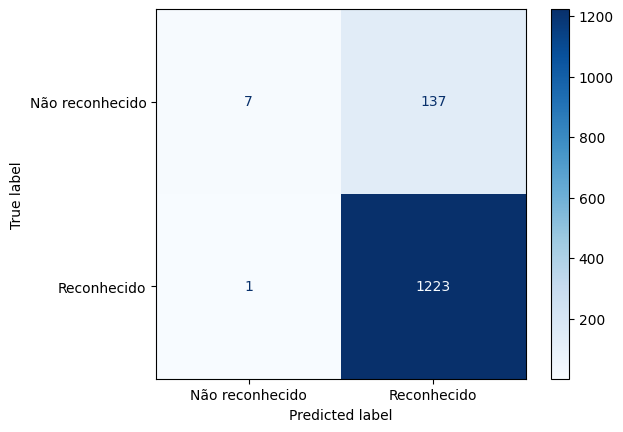

In [42]:
# Matriz de Confusão
ConfusionMatrixDisplay.from_estimator(best_rf_class_0_model, X_test_selected, y_test, values_format='d', cmap='Blues', display_labels=['Não reconhecido', 'Reconhecido'])

### Correlação < 0.5

In [43]:
# Calcular a matriz de correlação
corr_matrix = X_train.corr()

# Criar um dataframe para armazenar os pares com alta correlação
high_corr_pairs = set()

# Iterar pela matriz de correlação e encontrar pares com correlação acima de 0.5
threshold = 0.5
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) >= threshold:
            # Adicionar os pares de features com correlação maior que o threshold
            high_corr_pairs.add((corr_matrix.columns[i], corr_matrix.columns[j]))

# Exibir os pares com alta correlação
print(f'Pares de features com correlação maior que {threshold}:')
print(high_corr_pairs)

# Remover uma feature de cada par com alta correlação
features_to_remove = {pair[1] for pair in high_corr_pairs}  # Remover a segunda feature em cada par
X_train_uncorrelated = X_train.drop(columns = features_to_remove)
X_test_uncorrelated = X_test.drop(columns = features_to_remove)

# Exibir as features que foram removidas
print(f'Features removidas devido à alta correlação: {features_to_remove}')
print('Número de Features removidas:', len(features_to_remove))

Pares de features com correlação maior que 0.5:
{('DM_Obras de Infra Valor', 'DH_MORTOS'), ('DM_Uni Habita Valor', 'DH_DESAPARECIDOS'), ('PEPL_distrib energia (R$)', 'DM_Obras de Infra Valor'), ('PEPL_Tran loc/reg/l_curso (R$)', 'DM_Obras de Infra Valor'), ('PEPR_Serviços (R$)', 'DM_Uni Habita Valor'), ('DM_Obras de Infra Valor', 'DH_DESAPARECIDOS'), ('PEPL_distrib energia (R$)', 'DH_MORTOS'), ('DM_Obras de Infra Valor', 'DM_Uni Habita Valor'), ('PEPL_Tran loc/reg/l_curso (R$)', 'DH_MORTOS'), ('PEPR_Serviços (R$)', 'DH_MORTOS'), ('DM_Uni Habita Valor', 'DH_MORTOS'), ('PEPL_distrib energia (R$)', 'DH_DESAPARECIDOS'), ('PEPL_distrib energia (R$)', 'DM_Uni Habita Valor'), ('PEPL_Tran loc/reg/l_curso (R$)', 'DH_DESAPARECIDOS'), ('PEPL_Ensino (R$)', 'PEPL_Sis limp e rec lixo (R$)'), ('PEPL_Tran loc/reg/l_curso (R$)', 'DM_Uni Habita Valor'), ('DH_DESAPARECIDOS', 'DH_MORTOS')}
Features removidas devido à alta correlação: {'PEPL_Sis limp e rec lixo (R$)', 'DH_MORTOS', 'DM_Obras de Infra Valor'

In [44]:
# Treinamento

# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes = {
    'rf_class_0__criterion': ['gini', 'entropy'],
    'rf_class_0__n_estimators': [150, 175, 200, 225, 250, 300],
    'rf_class_0__max_depth': [2, 4, 6, 8],
    'rf_class_0__min_samples_split': [2, 5, 10, 15, 100],
    'rf_class_0__min_samples_leaf': [1, 2, 5, 10],
    'rf_class_0__max_features': ['sqrt', 'log2', None]
}

# Criar pipeline com RobustScaler e RandomForestClassifier
pipeline_rf_class_0 = Pipeline([
    ('scaler', RobustScaler()),
    ('rf_class_0', RandomForestClassifier(random_state = 42))
])

# Realizar a busca bayesiana com validação cruzada
bayes_search_rf_class_0 = BayesSearchCV(
    pipeline_rf_class_0,
    search_spaces = param_grid_bayes,
    n_iter = 30,
    cv = 5,
    scoring = 'f1_weighted',
    n_jobs = -1,
    random_state = 42
)

# Ajustar a busca bayesiana ao conjunto de treino
bayes_search_rf_class_0.fit(X_train_uncorrelated, y_train)

# Melhor modelo encontrado
best_rf_class_0_model = bayes_search_rf_class_0.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros: {bayes_search_rf_class_0.best_params_}")

# Fazer previsões com o conjunto de teste
y_pred_rf_class_0 = best_rf_class_0_model.predict(X_test_uncorrelated)

# Relatório de classificação TREINO
classification_report_rf_class_0 = metrics.classification_report(y_train, best_rf_class_0_model.predict(X_train_uncorrelated), digits = 6, target_names = ['Não reconhecido', 'Reconhecido'])
print('\n Classification report para Random Forest [TREINO]: \n')
print(classification_report_rf_class_0)

# Relatório de classificação TESTE
classification_report_rf_class_0 = metrics.classification_report(y_test, y_pred_rf_class_0, digits = 6, target_names = ['Não reconhecido', 'Reconhecido'])
print('\n Classification report para Random Forest [TESTE]: \n')
print(classification_report_rf_class_0)

Melhores hiperparâmetros: OrderedDict([('rf_class_0__criterion', 'gini'), ('rf_class_0__max_depth', 8), ('rf_class_0__max_features', None), ('rf_class_0__min_samples_leaf', 2), ('rf_class_0__min_samples_split', 2), ('rf_class_0__n_estimators', 300)])

 Classification report para Random Forest [TREINO]: 

                 precision    recall  f1-score   support

Não reconhecido   1.000000  0.119584  0.213622       577
    Reconhecido   0.905943  1.000000  0.950651      4893

       accuracy                       0.907130      5470
      macro avg   0.952972  0.559792  0.582137      5470
   weighted avg   0.915865  0.907130  0.872906      5470


 Classification report para Random Forest [TESTE]: 

                 precision    recall  f1-score   support

Não reconhecido   0.818182  0.062500  0.116129       144
    Reconhecido   0.900516  0.998366  0.946920      1224

       accuracy                       0.899854      1368
      macro avg   0.859349  0.530433  0.531524      1368
   weigh

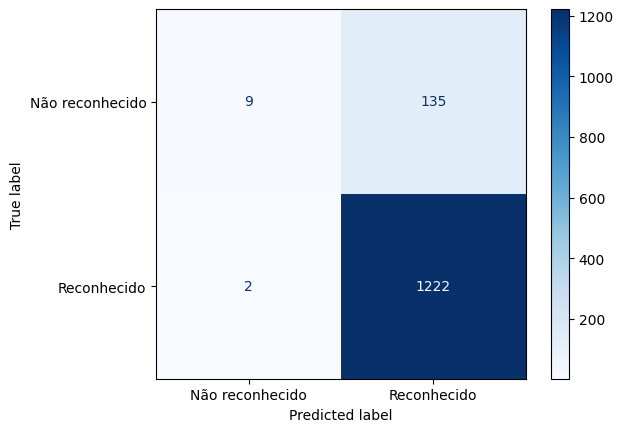

In [45]:
# Matriz de Confusão
ConfusionMatrixDisplay.from_estimator(best_rf_class_0_model, X_test_uncorrelated, y_test, values_format='d', cmap='Blues', display_labels=['Não reconhecido', 'Reconhecido'])